I noticed that intraday forex patterns need to be mean reverting, especially after what happens between 8:00 am and 14:00. I would like to backtest a simple strategy:

1 - First, we analyze the rally between 08:00 and 14:00. If it is a clear trend upward or downward, we take an opposite position at 14:01. We then exit the market as soon as we meet our take profit or stop loss rule.
2 - There are multiple ways to identify if a rally is trend upward or downward, we'll try different setups:
a) By checking the distribution of historical returns between 08:00 and 14:00, a trend will be anything belonging in the tail of the distribution (we will try different threshold of nb of std deviations)
b) By checking if the rally between 08:00 and 14:00 is significantly over the preceding average between 00:00 and 7:59
c) By checking the volume 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#df = pd.read_csv('/root/QuantAndCo/Data/forex/EUR_USD/1h/OHLC/2019-07-19 13:31:16_2024-04-19 16:11:16.csv')
#df.close_time = pd.to_datetime(df.close_time)
#df.set_index('close_time', inplace=True)

In [2]:
def calculate_periodic_returns(df, start_time, end_time):
    df = df.copy()

    start_prices = df.at_time(start_time)
    end_prices = df.at_time(end_time)

    start_prices['date'] = start_prices.index.normalize().date
    end_prices['date'] = end_prices.index.normalize().date

    start_prices.set_index('date', inplace=True)
    end_prices.set_index('date', inplace=True)


    comb_df = pd.merge(start_prices, end_prices, left_index=True, right_index=True, suffixes=('_start', '_end'))

    return comb_df


def plot_histogram(df, start_time, end_time, column="Close"):

    returns = df[f"{column}_end"] / df[f"{column}_start"] - 1

    start_date, end_date = df.index[0], df.index[-1]

    mean_returns = returns.mean()
    std_returns = returns.std()

    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=50, alpha=0.75, color='blue')
    plt.title(f'Histogram of Intraday Returns between {start_time} and {end_time} \n {start_date} to {end_date}')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    
    # Standard deviation lines
    for i in range(1, 4):
        plt.axvline(x=mean_returns + i*std_returns, color='r', linestyle='dashed', linewidth=1, label=f'Mean + {i} STD')
        plt.axvline(x=mean_returns - i*std_returns, color='g', linestyle='dashed', linewidth=1, label=f'Mean - {i} STD')

    plt.grid(True)
    plt.legend()
    plt.show()

    return mean_returns, std_returns


def MeanReversionIntraday(df, start_time, end_time, 
                          last_train_date, price_column, long_thres, short_thres):
    train_df = df.loc[df.index<=last_train_date]
    comb_train = calculate_periodic_returns(train_df, start_time, end_time)
    mu, sigma = plot_histogram(comb_train, start_time, end_time, price_column)
    test_df_init = df.loc[df.index > last_train_date]

    comb_test = calculate_periodic_returns(test_df_init, start_time, end_time)

    end_test_time = datetime.strptime(end_time, '%H:%M') + timedelta(minutes=1)
    str_test_time = end_test_time.strftime('%H:%M')

    test_df = test_df_init.between_time(str_test_time, '23:59')

    test_df['date'] = test_df.index.normalize().date
    test_df.date = pd.to_datetime(test_df.date)
    comb_test[f"{start_time[:2]}-{end_time[:2]}_return"] = (comb_test[f"{price_column}_end"] - comb_test[f"{price_column}_start"]) / comb_test[f"{price_column}_start"]
    test_returns = comb_test[[f"{start_time[:2]}-{end_time[:2]}_return"]]
    test_returns.index = pd.to_datetime(test_returns.index)

    test_df.reset_index(inplace=True)
    test_df.set_index('date', inplace=True)
    test_df.index = pd.to_datetime(test_df.index)


    test_df = test_df[["close_time", "Close"]]

    test_df = pd.merge(test_df, test_returns, right_index=True, left_index=True, how='left')

    return_col = f"{start_time[:2]}-{end_time[:2]}_return"

    test_df["signal"] = (test_df[return_col] <= mu + long_thres * sigma) * 1 + (test_df[return_col] >= mu + short_thres * sigma) * -1

    test_df = pd.merge(test_df_init, test_df.set_index('close_time').drop(columns="Close"), right_index=True, left_index=True, how='left')
    test_df["signal"].ffill(inplace=True)
    test_df[return_col].ffill(inplace=True)

    test_df["timestamp"] = pd.to_datetime(test_df.index)
    previous_hour = str(int(end_time[:2]) - 1) + ':59'
    filtered_df = test_df[(test_df["timestamp"].dt.time >= pd.to_datetime('00:00').time()) & (test_df["timestamp"].dt.time <= pd.to_datetime(end_time).time())]

    test_df.loc[filtered_df.index, "signal"] = 0 #always exit the position at the end of the day and can only re-start after end_time
    
    return test_df

In [36]:
def vectorized_backtesting(df, leverage, fees, initial_wealth=10_000, price_column='Close',
                           stop_loss=-1, take_profit=1):


    # Avoid look-ahead bias by shifting the signal forward by one period
    # Signals effectively become actionable the next bar
    df['position'] = df['signal'].shift(1).fillna(0) * leverage


    # Calculate daily returns for each asset
    df["return"] = df[price_column].pct_change().fillna(0)

    df["net_position_change"] = df['position'].diff().abs()

    # Calculate portfolio changes from returns
    df['portfolio_change'] = df[f'position'].shift(1) * df['return']

    # Determine positions where we go from 0 to 1 or -1
    df['new_position'] = (df['position'] != 0) & (df['position'].shift(1) == 0)

    # Set the entry price only when 'new_position' is True
    df['entry_price'] = df.apply(lambda row: row[price_column] if row['new_position'] else np.nan, axis=1)

    # Forward fill the entry prices to apply them until the position changes
    df['entry_price'].ffill(inplace=True)

    # Calculate unrealized pnl
    df['unrealized_pnl'] = df["position"].shift(1) * ( (df[price_column] - df['entry_price']) / df['entry_price'] )

    df['stop_triggered'] = ((df['unrealized_pnl'] <= stop_loss) | (df['unrealized_pnl'] >= take_profit)).shift(1).fillna(False)

    df['position'] = df.apply(lambda row: 0 if row['stop_triggered'] else row['position'], axis=1)

    df['net_position_change'] = df['position'].diff().abs()
    df['portfolio_change'] = df['position'].shift(1) * df['return']

    # Calculate cumulative wealth starting from initial_wealth
    df['Wealth'] = (1+df['portfolio_change'] - fees * df["net_position_change"].shift(1)).cumprod() * initial_wealth
    df["fees"] = fees * df["Wealth"].shift(1) * df["net_position_change"].shift(1)

    

    return df

In [22]:
#signal_df = MeanReversionIntraday(df, start_time='08:00', end_time='13:00', 
#                                  last_train_date='2020-06-01', price_column="Close", 
#                                  long_thres=-1, short_thres=1)

In [23]:
#stop dans le temps -> tous les jours 


In [24]:
#Value at Risk & Max Drawdown
#size betting -> levier proportionnel au z-score pour le pair trading

#>= 15%/mois avec - fréquence de drawdown > 10%


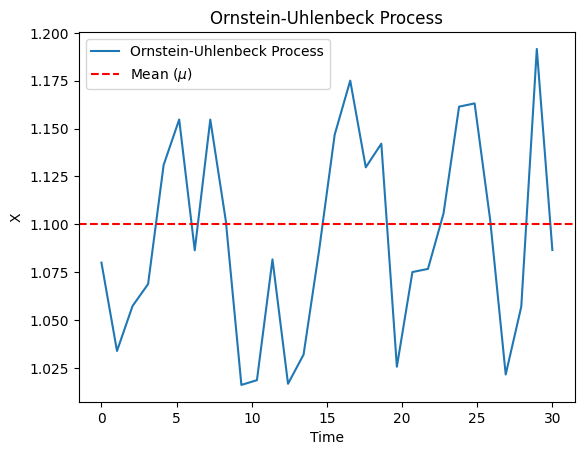

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def ornstein_uhlenbeck_process(mu, theta, sigma, X0, dt, T):
    """
    Simulate an Ornstein-Uhlenbeck process.

    Parameters:
    mu (float): Long-term mean
    theta (float): Rate of reversion to the mean
    sigma (float): Volatility parameter
    X0 (float): Initial value
    dt (float): Time step
    T (float): Total time

    Returns:
    np.ndarray: Simulated values of the process
    """
    N = int(T / dt)
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X0
    for i in range(1, N):
        dW = np.sqrt(dt) * np.random.normal()
        X[i] = X[i-1] + theta * (mu - X[i-1]) * dt + sigma * dW
    
    return t, X

# Parameters
mu = 1.1      # Long-term mean
theta = 0.6  # Rate of reversion
sigma = 0.05    # Volatility
X0 = 1.08       # Initial value
T = 30      # Total time
dt = 1
N = int(T / dt)

# Simulate the process
t, X = ornstein_uhlenbeck_process(mu, theta, sigma, X0, dt, T)

# Plot the results
plt.plot(t, X, label='Ornstein-Uhlenbeck Process')
plt.axhline(mu, color='r', linestyle='--', label='Mean ($\mu$)')
plt.xlabel('Time')
plt.ylabel('X')
plt.legend()
plt.title('Ornstein-Uhlenbeck Process')
plt.show()


In [26]:
# Set the start date
start_date = pd.Timestamp('2023-05-01')  # Replace with your desired start date

# Set the number of days
num_days = N  # Replace with the desired number of days

# Generate the date range
date_range = pd.date_range(start=start_date, periods=num_days, freq='D')

# Create an empty DataFrame with the generated date range as the index
df = pd.DataFrame(index=date_range, data=X)
df.columns=["Close"]

In [27]:
def mean_reverting_strategy(df, long_thres, short_thres, price_column="Close"):
    df["signal"] = (df[price_column] <= long_thres) * 1 + (df[price_column] >= short_thres) * -1
    return df

mu = 1.1
sigma = 0.05
long_thres = mu - 1 * sigma
short_thres = mu + 1 * sigma
df = mean_reverting_strategy(df, long_thres, short_thres)



<Axes: >

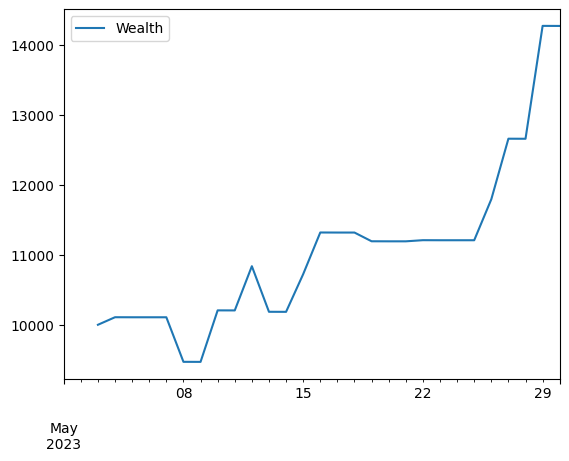

In [37]:
bt = vectorized_backtesting(df, leverage=1, fees=0.00007)
bt[["Wealth"]].plot()

In [42]:
# Step 1: Identify the rows where the conditions are met

trades = (bt['net_position_change'] != 0) & (bt['position'] == 0)
trades_df = bt[trades.fillna(False)]

trades_df.dropna()

,Close,signal,position,return,net_position_change,portfolio_change,new_position,entry_price,unrealized_pnl,stop_triggered,Wealth,fees
2023-05-04,1.068817,0,0.0,0.010848,1.0,0.010848,False,1.057347,0.010848,False,10107.777994,0.700000
2023-05-08,1.154720,-1,0.0,0.062848,1.0,-0.062848,False,1.086439,-0.062848,False,9471.153893,0.707495
2023-05-10,1.016133,1,0.0,-0.077692,1.0,0.077692,False,1.101728,0.077692,False,10205.610678,0.662934
2023-05-13,1.016728,1,0.0,-0.060049,1.0,-0.060049,False,1.018617,-0.001854,False,10185.302600,0.000000
2023-05-16,1.146810,0,0.0,0.055474,1.0,0.055474,False,1.031985,0.111266,False,11317.032165,0.000000
2023-05-19,1.142131,0,0.0,0.010931,1.0,-0.010931,False,1.129781,-0.010931,False,11191.750012,0.792137
2023-05-22,1.076733,0,0.0,0.001524,1.0,0.001524,False,1.075094,0.001524,False,11207.240460,0.783368
2023-05-27,1.021583,1,0.0,-0.073304,1.0,0.073304,False,1.163171,0.121726,False,12655.584924,0.000000
2023-05-29,1.191622,-1,0.0,0.127384,1.0,0.127384,False,1.056980,0.127384,False,14265.818583,0.885829


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def ornstein_uhlenbeck_process(mu, theta, sigma, X0, dt, T):
    """
    Simulate an Ornstein-Uhlenbeck process.

    Parameters:
    mu (float): Long-term mean
    theta (float): Rate of reversion to the mean
    sigma (float): Volatility parameter
    X0 (float): Initial value
    dt (float): Time step
    T (float): Total time

    Returns:
    np.ndarray: Simulated values of the process
    """
    np.random.seed(901)

    N = int(T / dt)
    t = np.linspace(0, T, N)
    X = np.zeros(N)
    X[0] = X0
    for i in range(1, N):
        dW = np.sqrt(dt) * np.random.normal()
        X[i] = X[i-1] + theta * (mu - X[i-1]) * dt + sigma * dW
    
    return t, X

def mean_reverting_strategy(df, long_thres, short_thres, price_column="Close"):
    df["signal"] = (df[price_column] <= long_thres) * 1 + (df[price_column] >= short_thres) * -1

    return df

def simulate_data(start_date, n_dates, data, frequency='D'):
    # Generate the date range
    date_range = pd.date_range(start=start_date, periods=n_dates, freq=frequency)
    # Create an empty DataFrame with the generated date range as the index
    df = pd.DataFrame(index=date_range, data=data)
    df.columns=["Close"]
    return df



# Parameters
mu = 1.1      # Long-term mean
theta = 0.01  # Rate of reversion
sigma = 0.02    # Volatility
X0 = 1.08       # Initial value
T = 252       # Total time
dt = 1
N = int(T / dt)

long_thres = mu - 3 * sigma
short_thres = mu + 3 * sigma

# Simulate the process
t, X = ornstein_uhlenbeck_process(mu, theta, sigma, X0, dt, T)

df = simulate_data(start_date='2023-01-01', n_dates=N, data=X, frequency='D')
df = mean_reverting_strategy(df, long_thres, short_thres)


bt_df = vectorized_backtesting(df, leverage=1, fees=0.00007, initial_wealth=10_000)

In [82]:
df.loc[df.index>='2023-03-03'].head(10)

,Close,signal,position,return,net_position_change,portfolio_change,new_position,entry_price,unrealized_pnl,stop_triggered,Wealth,fees
2023-03-03,1.067530,0,0.0,0.000036,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-04,1.087876,0,0.0,0.019059,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-05,1.101320,0,0.0,0.012358,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-06,1.101414,0,0.0,0.000085,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-07,1.119605,0,0.0,0.016516,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-08,1.133716,0,0.0,0.012604,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-09,1.152500,0,0.0,0.016568,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-10,1.156455,0,0.0,0.003432,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-11,1.183907,-1,0.0,0.023738,0.0,0.0,False,1.016611,0.0,False,9744.840629,0.0
2023-03-12,1.168653,-1,-1.0,-0.012884,1.0,-0.0,True,1.168653,0.0,False,9744.840629,0.0


In [83]:
short_entries

,Close,signal,position,return,net_position_change,portfolio_change,new_position,entry_price,unrealized_pnl,stop_triggered,Wealth,fees
2023-03-25,1.154168,0,-1.0,-0.024887,0.0,0.024887,False,1.168653,0.012395,False,9837.326670,0.0
2023-04-08,1.159833,0,-1.0,-0.036895,0.0,0.036895,False,1.207130,0.039182,False,10301.143701,0.0
2023-05-12,1.137153,0,-1.0,-0.044383,0.0,0.044383,False,1.193619,0.047306,False,10946.246749,0.0
2023-05-20,1.135286,0,-1.0,-0.025570,0.0,0.025570,False,1.185130,0.042057,False,11251.909970,0.0
2023-06-22,1.157343,0,-1.0,-0.027149,0.0,0.027149,False,1.206857,0.041027,False,11499.873944,0.0
2023-06-26,1.155805,0,-1.0,-0.010997,1.0,-0.000000,True,1.155805,0.000000,False,11536.576270,0.0
2023-07-01,1.152347,0,-1.0,-0.008717,0.0,0.008717,False,1.182787,0.025736,False,11729.756806,0.0


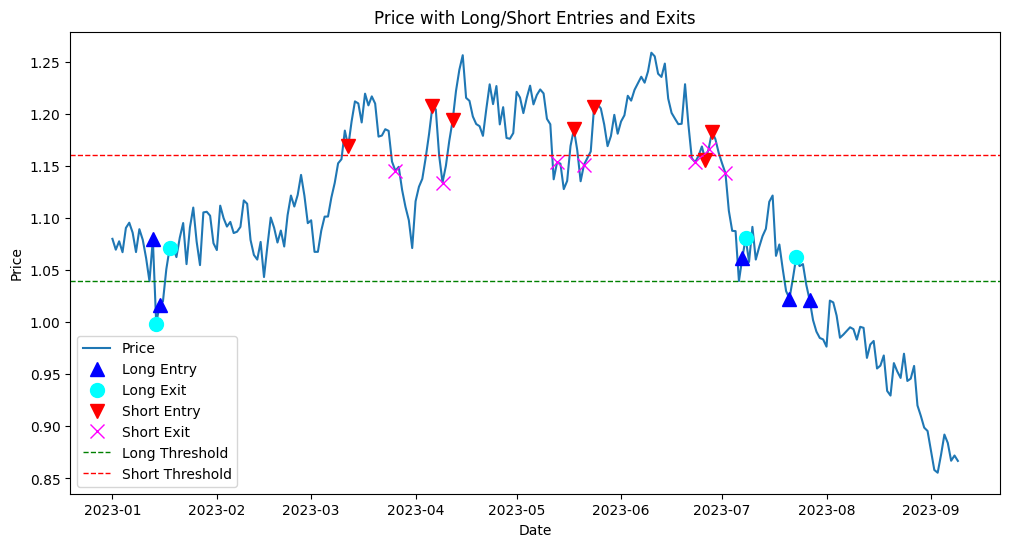

In [84]:
    
# Plotting the price data
plt.figure(figsize=(12, 6))
plt.plot(bt_df["Close"], label='Price')

long_entries = bt_df[(bt_df["position"].shift(1)!=1) & (bt_df["position"] == 1)]
long_exits = bt_df[(bt_df["position"].shift(1)==1) & (bt_df["position"] != 1)]

short_entries = bt_df[(bt_df["position"].shift(1)!=-1) & (bt_df["position"] == -1)]
short_exits = bt_df[(bt_df["position"].shift(1)== -1) & (bt_df["position"] != -1)]

# Plot long entries (blue upward triangles)
plt.plot(long_entries.index, long_entries["Close"], '^', markersize=10, color='blue', lw=0, label='Long Entry')

# Plot long exits (cyan circles)
plt.plot(long_exits.index, long_exits["Close"], 'o', markersize=10, color='cyan', lw=0, label='Long Exit')

# Plot short entries (red downward triangles)
plt.plot(short_entries.index, short_entries["Close"], 'v', markersize=10, color='red', lw=0, label='Short Entry')

# Plot short exits (magenta crosses)
plt.plot(short_exits.index, short_exits["Close"], 'x', markersize=10, color='magenta', lw=0, label='Short Exit')

# Plotting long and short thresholds as horizontal lines
plt.axhline(y=long_thres, color='green', linestyle='--', linewidth=1, label='Long Threshold')
plt.axhline(y=short_thres, color='red', linestyle='--', linewidth=1, label='Short Threshold')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price with Long/Short Entries and Exits')
plt.legend()

# Show the plot
plt.show()

array([[<Axes: title={'center': 'Close'}>]], dtype=object)

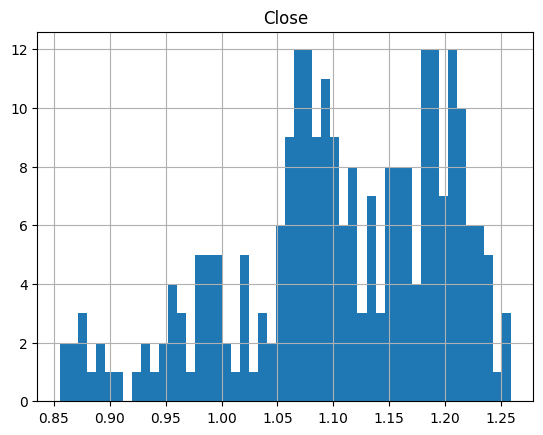

In [75]:
df[["Close"]].hist(bins=50)

/tmp/ipykernel_1032565/2248590751.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_prices['date'] = start_prices.index.normalize().date
/tmp/ipykernel_1032565/2248590751.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_prices['date'] = end_prices.index.normalize().date


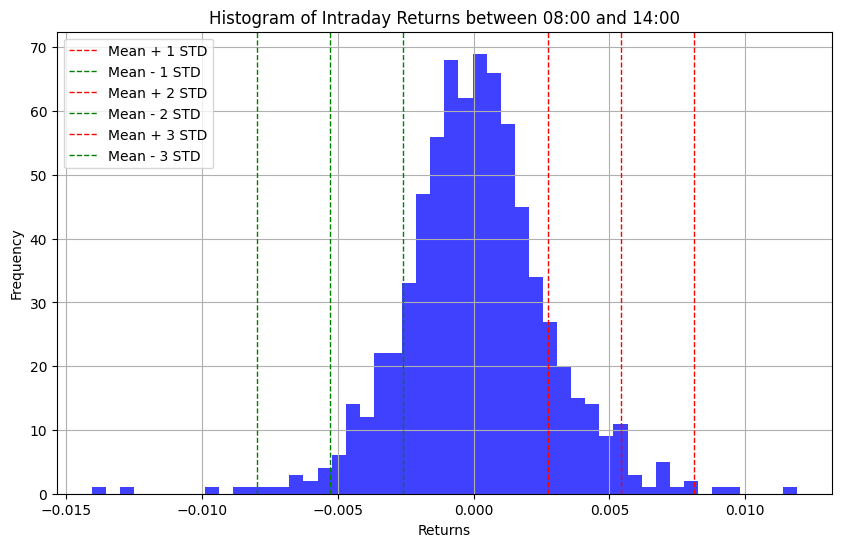

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('/root/QuantAndCo/Data/forex/EUR_USD/1m/OHLC/2019-07-19 13:31:16_2024-04-19 16:11:16.csv')
df.close_time = pd.to_datetime(df.close_time)
df.set_index('close_time', inplace=True)

last_train_date = '2022-06-01'

train_df = df.loc[df.index<=last_train_date]

def calculate_periodic_returns(df, start_time, end_time):
    df = df.copy()

    start_prices = df.at_time(start_time)
    end_prices = df.at_time(end_time)

    start_prices['date'] = start_prices.index.normalize().date
    end_prices['date'] = end_prices.index.normalize().date

    start_prices.set_index('date', inplace=True)
    end_prices.set_index('date', inplace=True)


    comb_df = pd.merge(start_prices, end_prices, left_index=True, right_index=True, suffixes=('_start', '_end'))

    return comb_df


comb_train = calculate_periodic_returns(train_df, '08:00', '14:00')


def plot_histogram(df, column="Close"):

    returns = df[f"{column}_end"] / df[f"{column}_start"] - 1

    mean_returns = returns.mean()
    std_returns = returns.std()

    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=50, alpha=0.75, color='blue')
    plt.title(f'Histogram of Intraday Returns between 08:00 and 14:00')
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    
    # Standard deviation lines
    for i in range(1, 4):
        plt.axvline(x=mean_returns + i*std_returns, color='r', linestyle='dashed', linewidth=1, label=f'Mean + {i} STD')
        plt.axvline(x=mean_returns - i*std_returns, color='g', linestyle='dashed', linewidth=1, label=f'Mean - {i} STD')

    plt.grid(True)
    plt.legend()
    plt.show()

    return mean_returns, std_returns

mu, sigma = plot_histogram(comb_train, 'Close')

In [15]:
last_train_date='2022-06-01'

test_df = df.loc[df.index > last_train_date]

comb_test = calculate_periodic_returns(test_df, '08:00', '14:00')

test_df = test_df.between_time('14:01', '23:59')

/tmp/ipykernel_1034105/4142317070.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_prices['date'] = start_prices.index.normalize().date
/tmp/ipykernel_1034105/4142317070.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_prices['date'] = end_prices.index.normalize().date


In [16]:
test_df['date'] = test_df.index.normalize().date
test_df.date = pd.to_datetime(test_df.date)
comb_test["8-14-return"] = (comb_test["Close_end"] - comb_test["Close_start"]) / comb_test["Close_start"]
test_returns = comb_test[["8-14-return"]]
test_returns.index = pd.to_datetime(test_returns.index)

test_df.reset_index(inplace=True)
test_df.set_index('date', inplace=True)
test_df.index = pd.to_datetime(test_df.index)


test_df = test_df[["close_time", "Close"]]

test_df = pd.merge(test_df, test_returns, right_index=True, left_index=True, how='left')

test_df["signal"] = (test_df["8-14-return"] <= mu - 1 * sigma) * 1 + (test_df["8-14-return"] >= mu + 1 * sigma) * -1




NameError: name 'mu' is not defined

In [17]:
test_df.reset_index(inplace=True)
test_df.set_index('date', inplace=True)
test_df.index = pd.to_datetime(test_df.index)

In [18]:
test_df = test_df[["close_time", "Close"]]

test_df = pd.merge(test_df, test_returns, right_index=True, left_index=True, how='left')

In [20]:
test_df["signal"] = (test_df["8-14-return"] <= mu - 1 * sigma) * 1 + (test_df["8-14-return"] >= mu + 1 * sigma) * -1

In [21]:
test_df = vectorized_backtesting(test_df, leverage=10, fees=0.00007)

<Axes: xlabel='date'>

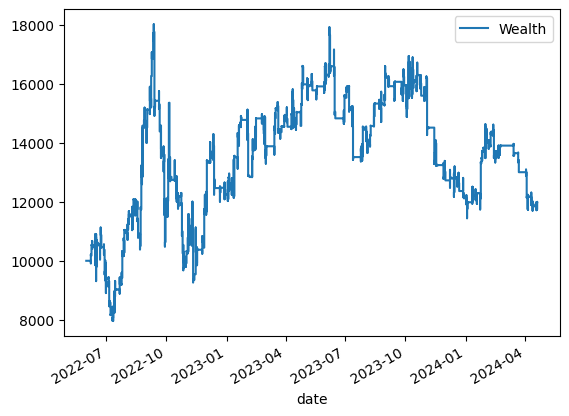

In [23]:
test_df[["Wealth"]].plot()

In [28]:
rt=((1.06770/1.07388 - 1)*-10) +1
10_000*rt

10575.4832942228

In [33]:
9972.509342*(1-0.002514)

9947.43845351421

In [31]:
bt.loc[(bt.close_time>='2022-06-08 14:01:00') & (bt.close_time<="2022-06-08 16:00")].head(20)

,close_time,Close,8-14-return,signal,position,return,net_position_change,portfolio_change,Wealth,fees
date,,,,,,,,,,
2022-06-08,2022-06-08 14:01:00+00:00,1.07366,0.004997,0.0,0.0,0.003646,0.0,0.000000,10000.000000,0.0
2022-06-08,2022-06-08 14:02:00+00:00,1.07388,0.004997,-1.0,-10.0,0.000205,10.0,-0.002049,10000.000000,0.0
2022-06-08,2022-06-08 14:03:00+00:00,1.07415,0.004997,-1.0,-10.0,0.000251,0.0,-0.002514,9972.509342,7.0
2022-06-08,2022-06-08 14:04:00+00:00,1.07411,0.004997,-1.0,-10.0,-0.000037,0.0,0.000372,9947.435986,0.0
2022-06-08,2022-06-08 14:05:00+00:00,1.07418,0.004997,-1.0,-10.0,0.000065,0.0,-0.000652,9951.140287,0.0
2022-06-08,2022-06-08 14:06:00+00:00,1.07408,0.004997,-1.0,-10.0,-0.000093,0.0,0.000931,9944.655105,0.0
2022-06-08,2022-06-08 14:07:00+00:00,1.07452,0.004997,-1.0,-10.0,0.000410,0.0,-0.004097,9953.913009,0.0
2022-06-08,2022-06-08 14:08:00+00:00,1.07437,0.004997,-1.0,-10.0,-0.000140,0.0,0.001396,9913.136515,0.0
2022-06-08,2022-06-08 14:09:00+00:00,1.07422,0.004997,-1.0,-10.0,-0.000140,0.0,0.001396,9926.974977,0.0


In [25]:
bt.loc[bt.signal.diff()!=0]

,close_time,Close,8-14-return,signal,position,return,net_position_change,portfolio_change,Wealth,fees
date,,,,,,,,,,
2022-06-01,2022-06-01 14:01:00+00:00,1.06902,-0.001764,0.0,0.0,0.000000,NaN,0.000000,NaN,NaN
2022-06-08,2022-06-08 14:02:00+00:00,1.07388,0.004997,-1.0,-10.0,0.000205,10.0,-0.002049,10000.000000,0.0
2022-06-09,2022-06-09 14:02:00+00:00,1.06770,-0.001561,0.0,0.0,-0.000178,10.0,-0.000000,10535.708471,0.0
2022-06-10,2022-06-10 14:02:00+00:00,1.05164,-0.009741,1.0,10.0,-0.000219,10.0,-0.002187,10528.333476,0.0
2022-06-12,2022-06-12 21:05:00+00:00,1.05162,NaN,0.0,0.0,0.000057,10.0,0.000000,10485.276537,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-04-11,2024-04-11 14:02:00+00:00,1.07325,-0.001378,0.0,0.0,0.000252,10.0,0.000000,12824.680542,0.0
2024-04-12,2024-04-12 14:02:00+00:00,1.06409,-0.004156,1.0,10.0,0.000197,10.0,0.001974,12815.703266,0.0
2024-04-14,2024-04-14 21:05:00+00:00,1.06366,NaN,0.0,0.0,-0.000028,10.0,-0.000000,12781.603749,0.0


<Axes: xlabel='date'>

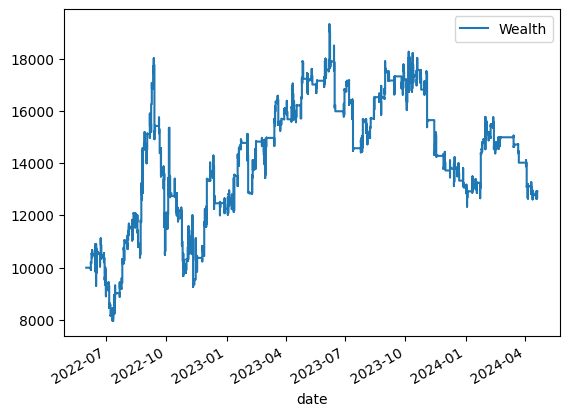

In [23]:
bt[["Wealth"]].plot()